### Comparison between the A/E method and the Deep Learning autoencoder + classifier method
This notebooks allows for comparing the two SSE/MSE classifiers in terms of S/B gain for peaks at different, customizable energies. For each peak, the Comparison class carries out the following analysis steps:
- Selecting an energy region centered at the peak value +- a certain energy span.
- Selecting MSE events inside the energy region with a first method ("nn" or "avse"), looping through a set of thresholds. The threshold for the second method is adjusted in order to match the same event number as the first method.
- Estimating the S/B ratio and its standard deviation with robust fitting for each peak and threshold value.

In [1]:
from begepro.autoencoder.sn_analysis import Comparison, compute_threshold
from begepro.autoencoder.dataloading import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
opts = {"loadpath": "/mnt/e/BEGE_data/waveforms_crioconite", # where .bin files are stored
"savepath": "../../dataset/Th232", # where .npy files will be saved with readfiles() and loaded with load()
"subsampling_factor": 3}

dloader = DataLoader(opts)
_, _, energies, _, _ = dloader.load()

opts_2 = {"loadpath": "/mnt/e/BEGE_data/waveforms_crioconite", # where .bin files are stored
"savepath": "../../dataset/Th232_2", # where .npy files will be saved with readfiles() and loaded with load()
"subsampling_factor": 3}

dloader_2 = DataLoader(opts_2)
_, _, energies_2, _, _ = dloader_2.load()

In [3]:
preds = np.load("../../preds_ratios/preds_Th232.npy")[:,0]
ratio = np.load("../../preds_ratios/ratios_Th232.npy")

energies = np.concatenate([energies, energies_2])
test_mask = np.load("../../dataset/Th232_splitting_map/test.npy")
energies = energies[test_mask.astype(int)]

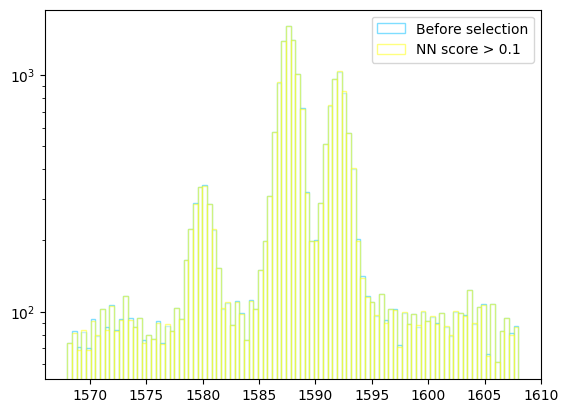

In [4]:
scoresel = 0.1
predictions_nn = preds > scoresel
enmask = np.logical_and(energies > 1568, energies < 1608)
avse_threshold = compute_threshold(ratio[enmask], predictions_nn[enmask].sum(), "avse", stress_limit = 100000)
nbins = 97
# plt.hist(energies, range = [1568, 1608], bins = nbins, ec = "red", facecolor="white")[-1]
plt.hist(energies[predictions_nn], range = [1568, 1608], bins = nbins, ec = "deepskyblue", facecolor="white", alpha = 0.5)[-1]
plt.hist(energies[ratio < avse_threshold], range = [1568, 1608], bins = nbins, ec = "yellow", facecolor="white", alpha = 0.5)[-1]
# plt.hist(energies[predictions_nn], range = [468, 488], bins = nbins, ec = "deepskyblue", facecolor="white")[-1]
                                            
plt.legend(["Before selection", f"NN score > {scoresel}", f"A/E cut < {avse_threshold}"])
plt.yscale("log")

In [5]:
comparison = Comparison(energies, ratio, preds)
M_ELECTRON = 511
cs = np.linspace(0.0, 0.7, 70)
peaks = [2615, 2615 - 1*M_ELECTRON, 2615 - 2*M_ELECTRON, 1588, 1622, 1460, 860, 835, 409, 583, 2177]


In [6]:
sb_nn, std_sb_nn, sb_avse, std_sb_avse, avse_thresholds = comparison.compare(peaks, cs, benchmark = "nn", width=  20, nbins = 97)

Estimating S/B for peak at 2615 keV
Estimating S/B for peak at 2104 keV
Estimating S/B for peak at 1593 keV


/home/rmoretti/BEGe/BEGepro/begepro/autoencoder/sn_analysis.py:111: UserWarning: The fit did not converge.
  warnings.warn("The fit did not converge.")


Estimating S/B for peak at 1588 keV
Estimating S/B for peak at 1622 keV
Estimating S/B for peak at 1460 keV
Estimating S/B for peak at 860 keV
Estimating S/B for peak at 835 keV
Estimating S/B for peak at 409 keV
Estimating S/B for peak at 583 keV
Estimating S/B for peak at 2177 keV


In [7]:
plt.rc('xtick', labelsize=8) 
for n in range(len(peaks)):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()

    ax1.plot(cs, sb_nn[:,n], color =  'deepskyblue')
    ax1.fill_between(cs, sb_nn[:,n] + std_sb_nn[:,n], sb_nn[:,n] - std_sb_nn[:,n],label='_nolegend_', alpha = 0.5, color = 'skyblue')
    ax1.plot(cs, sb_avse[:,n], color = 'red')
    ax1.fill_between(cs, sb_avse[:,n] + std_sb_avse[:,n], sb_avse[:,n] - std_sb_avse[:,n], color = 'coral', label='_nolegend_', alpha = 0.5)

    d = 10
    new_tick_locations = np.array(cs[::d])

    ax1.set_xticks(cs[::d])

    ax1.set_xticklabels(["> "+str(round(float(c), 2)) for c in cs[::d]])

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(cs[::d])
    ax2.set_xticklabels(["< "+str(round(float(avse_threshold*100), 2)) for avse_threshold in avse_thresholds[::d,n]])

    ax1.set_xlabel("NN score threshold")
    ax2.set_xlabel("A/E score threshold [x 100]")
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("axes", -0.15))

    ax1.set_ylabel("S/B ratio")
    plt.title(f"Peak at {peaks[n]} keV")
    ax1.legend(["NN", "A/E"])
    plt.savefig(f"../../results/zz_peak_at_{peaks[n]}_122_sampling_.svg", bbox_inches='tight')
    plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Visualizing the S/B estimation process

In [8]:
from scipy.signal import find_peaks
import warnings
from begepro.autoencoder.sn_analysis import exclude_unwanted_peaks
from scipy.optimize import curve_fit
import numpy as np

def sb_fit_function(x, a, b, mu, sigma, c):
    return a * np.exp(-(x-mu)**2/(2*sigma**2)) + b + c*(x-mu)

mu_true = 850 # Peak centre (expected)
width = 20 # Fit width in keV
nbins = 97# 97
masked_energies = energies[np.logical_and(energies < mu_true + width, energies > mu_true - width)]

hist = np.histogram(masked_energies, bins = nbins, range = [mu_true -width, mu_true +width])
ydata = hist[0]
xdata = (hist[1][:-1] +  hist[1][1:])/2 
sigma = np.sqrt(ydata)/ydata.sum()
sigma[sigma == 0] = 1
ydata = ydata/ydata.sum()
prominence = 0.001

while True:
    peaks, properties = find_peaks(ydata, prominence=prominence, width=1.5)
    if len(peaks) > 0:
        break
    else:
        prominence = prominence - 0.0001
    if prominence < 0:
        warnings.warn("No peaks found.")

a0 = 1
b0 = 0
mu0 = xdata[peaks[np.argmin(np.abs(xdata[peaks] - mu_true))]]
sigma0 = 3
c0 = 0

fit_mask = exclude_unwanted_peaks(xdata, peaks, properties, mu0)
xdata = xdata[fit_mask]
ydata = ydata[fit_mask]
sigma = sigma[fit_mask]

xdata = xdata[3:-3]
ydata = ydata[3:-3]

sigma = np.sqrt(ydata)
sigma[sigma == 0] = 1
popt, pcov = curve_fit(sb_fit_function, xdata, ydata, p0 = [a0, b0, mu0, sigma0, c0], sigma = sigma, maxfev = 100000, bounds=((0, 0, 0, 0, -1e5), (1e5, 1e5, 3e3, 20, 1)), method = "trf")

stds = np.sqrt(np.diag(pcov))
bkg = popt[1]
std_b = stds[1]
sig = popt[0]
std_s = stds[0]

sb = sig/bkg
std_sb = np.sqrt((std_s/bkg)**2 + (sig*std_b/bkg**2)**2 - sig/bkg**3*pcov[0, 1])

In [9]:
peaks

array([13, 24, 48, 73])

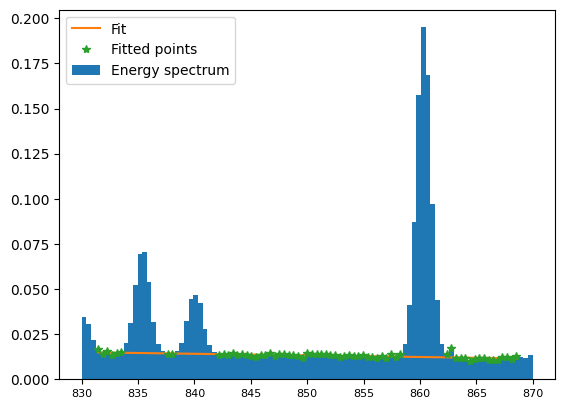

In [10]:
plt.hist(masked_energies, bins = nbins, range = [mu_true -width, mu_true +width], density = True)[-1]
plt.plot(xdata, sb_fit_function(xdata, popt[0], popt[1], popt[2], popt[3], popt[4])/(xdata[1] - xdata[0]))
plt.plot(xdata, ydata/(xdata[1] - xdata[0]), '*')
plt.legend(["Fit", "Fitted points", "Energy spectrum"])

In [11]:
90/4

22.5